
Importing Libraries

In [14]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import math
import pickle
import os
from xgboost import XGBClassifier
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading Data

In [16]:
from pandas import read_hdf
df_final_train = read_hdf('/content/drive/MyDrive/Colab Notebooks/facebook/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/MyDrive/Colab Notebooks/facebook/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [17]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

Adding Feature Preferential Attachment

In [18]:
def preferential_attachment(df_final):
    preferential_attachment_followers=[]
    preferential_attachment_followees=[]
    preferential_attachment_followers=df_final['num_followers_s']*df_final['num_followees_d']
    preferential_attachment_followees=df_final['num_followees_s']*df_final['num_followees_d']
    return preferential_attachment_followers,preferential_attachment_followees

In [19]:
(df_final_train[' preferential_attachment_followers'], df_final_train['preferential_attachment_followees'])= preferential_attachment(df_final_train)
(df_final_test[' preferential_attachment_followers'], df_final_test['preferential_attachment_followees'])= preferential_attachment(df_final_test)

In [34]:
os.path.isfile('/content/drive/MyDrive/Colab Notebooks/facebook/data/after_eda/train_after_eda.csv')
train_graph=nx.read_edgelist('/content/drive/MyDrive/Colab Notebooks/facebook/data/after_eda/train_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

In [35]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [36]:
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [37]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [38]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1862196, 1862196)
U Shape (1862196, 6)
V Shape (6, 1862196)
s Shape (6,)


**Adding Feature svd_dot**

svd_dot is the Dot product between source node svd and destination node svd features

In [40]:
def np_dot(df_final):
    # function product between source node and destination of svd features
    np_dot_u=[]
    np_dot_v=[]
    for i,row in df_final.iterrows():
        a=svd(row['source_node'],U)
        b=svd(row['destination_node'],U)
        np_dot_u.append(np.dot(a,b))
        c=svd(row['source_node'],V.T)
        d=svd(row['destination_node'],V.T)
        np_dot_v.append(np.dot(c,d))
        
    return np_dot_u,np_dot_v

In [41]:
(df_final_train['np_dot_u'],df_final_train['np_dot_v'])=np_dot(df_final_train)
(df_final_test['np_dot_u'],df_final_test['np_dot_v'])=np_dot(df_final_test)

In [42]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       ' preferential_attachment_followers',
       'preferential_attachment_followees', 'np_dot_u', 'np_dot_v'],
      dtype='obje

In [43]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [44]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9210492696844526 test Score 0.9162413689582708
Estimators =  50 Train Score 0.9672936481408329 test Score 0.9244996199645301
Estimators =  100 Train Score 0.9735266405276436 test Score 0.9260564875769803
Estimators =  150 Train Score 0.9749896254010667 test Score 0.9278140639579269
Estimators =  200 Train Score 0.9762109371050742 test Score 0.9244612733731838


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

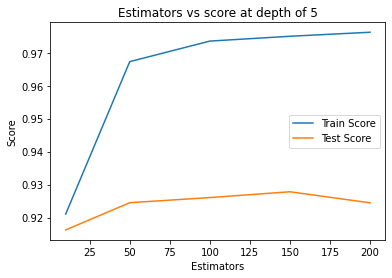

In [45]:
estimators = [10,50,100,150,200]
train_scores = []
test_scores = []
for i in estimators:
    clf =  XGBClassifier(n_estimators=i, n_jobs=-1)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.legend()
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9735266405276436 test Score 0.9260564875769803
depth =  9 Train Score 0.9869335613338027 test Score 0.9285456743515238
depth =  11 Train Score 0.9929263031154367 test Score 0.9269710600016974
depth =  15 Train Score 0.9997501873594804 test Score 0.9268944455048673
depth =  20 Train Score 1.0 test Score 0.9288300688194812


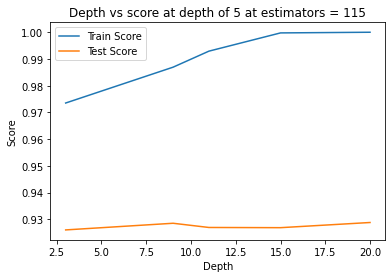

In [46]:
depths = [3,9,11,15,20]
train_scores = []
test_scores = []
for i in depths:
    clf =  XGBClassifier(max_depth=i, n_jobs=-1)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.legend()
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [47]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              'learning_rate': [0.1, 0.01, 0.05]
            }

clf =  XGBClassifier( n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=3,cv=3,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.97997939 0.97504595 0.97375853]
mean train scores [0.99951024 0.9904308  0.97881117]


In [48]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [49]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [50]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9735266405276436
Test f1 score 0.9260564875769803


In [52]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


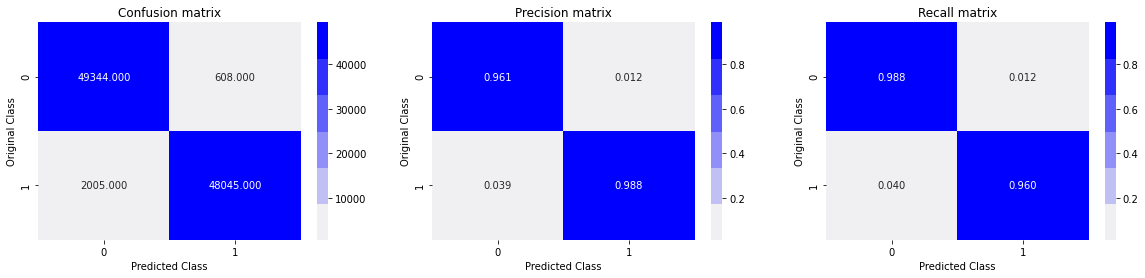

Test confusion_matrix


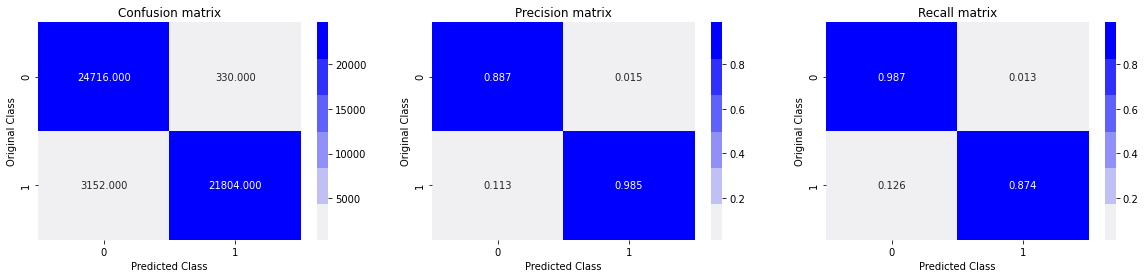

In [53]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

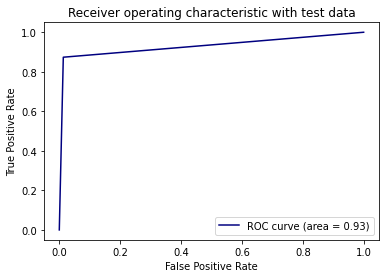

In [54]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

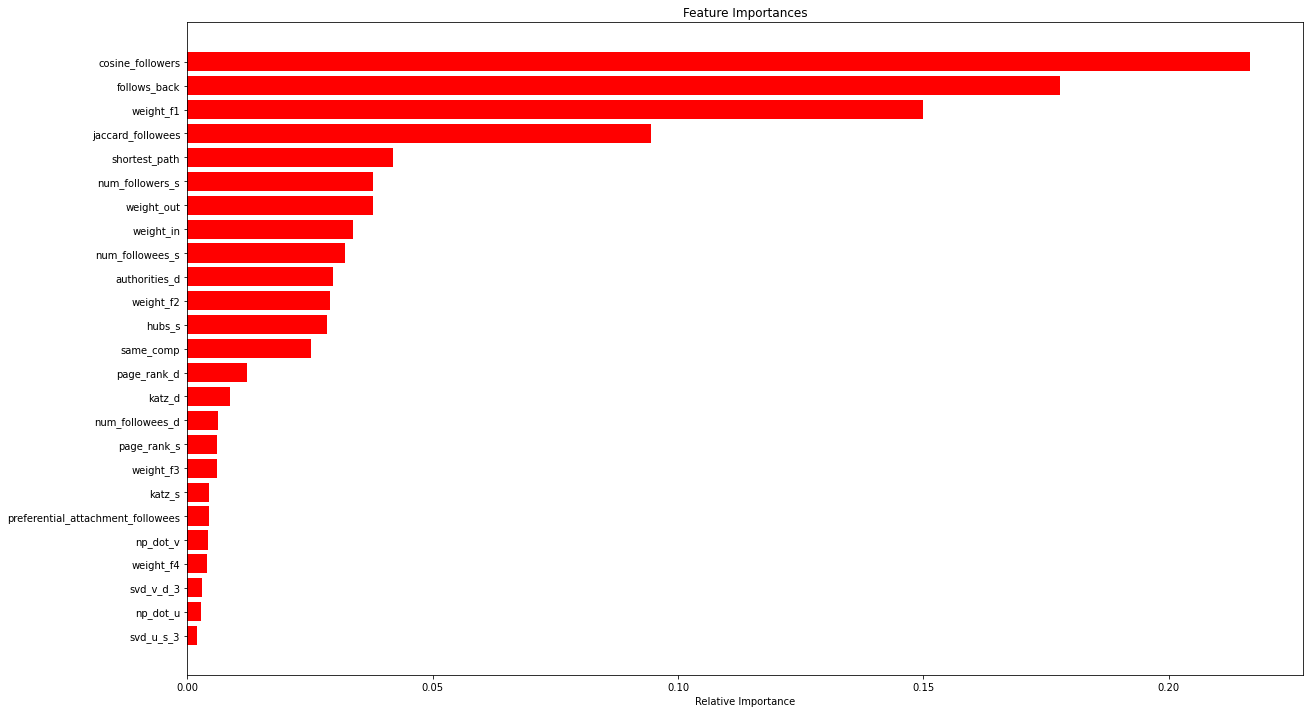

In [55]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(20,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Hyperparameter tuning XGBoost**

In [58]:
startTime = datetime.datetime.now()
print("Current Time = ",startTime)

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score,make_scorer

min_child_weight = [2,4,6]
max_depth = [2,4,6]
n_estimators =[100,200,300]
learning_rate = [0.1,0.2,0.3]

scorer = make_scorer(f1_score)
tuned_parameters = {
                    'min_child_weight':min_child_weight,
                    'max_depth':max_depth,
                    'n_estimators': n_estimators,
                    'learning_rate':learning_rate}

clf = xgb.XGBClassifier()
model_gbt = RandomizedSearchCV(clf,tuned_parameters,scoring =scorer,cv=3,pre_dispatch=2)
model_gbt.fit(df_final_train,y_train)
print(model_gbt.best_estimator_)

best_min_child_weight_xgb = model_gbt.best_estimator_.min_child_weight
best_max_depth_xgb = model_gbt.best_params_["max_depth"]
best_n_estimators_xgb = model_gbt.best_estimator_.n_estimators
best_learning_rate_xgb = model_gbt.best_estimator_.learning_rate

print("\nbest_min_child_weight_xgb = ", best_min_child_weight_xgb)
print("best_max_depth_xgb = ",best_max_depth_xgb)
print("best_n_estimators_xgb = ", best_n_estimators_xgb)
print("best_learning_rate_xgb = ",best_learning_rate_xgb)

print("Time taken for creation of dataframe is {}".format(datetime.datetime.now() - startTime))

Current Time =  2021-05-17 08:27:40.158577
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

best_min_child_weight_xgb =  4
best_max_depth_xgb =  4
best_n_estimators_xgb =  200
best_learning_rate_xgb =  0.3
Time taken for creation of dataframe is 0:19:30.468223


In [59]:
startTime = datetime.datetime.now()
print("Current Time = ",startTime)

xgb_best = xgb.XGBClassifier(objective='binary:logistic',learning_rate = best_learning_rate_xgb,
                             min_child_weight = best_min_child_weight_xgb,n_estimators = best_n_estimators_xgb,
                             max_depth = best_max_depth_xgb)
xgb_best.fit(df_final_train,y_train)
pred_train = xgb_best.predict(df_final_train)
pred_test = xgb_best.predict(df_final_test)

train_score = f1_score(y_train,pred_train)
test_score = f1_score(y_test,pred_test)
print('\nTrain Score: ',train_score)
print('Test Score: ',test_score)

print("Time taken for creation of dataframe is {}".format(datetime.datetime.now() - startTime))

Current Time =  2021-05-17 08:47:16.850941

Train Score:  0.9923572365850971
Test Score:  0.9056064444877543
Time taken for creation of dataframe is 0:01:22.747610


Train confusion_matrix


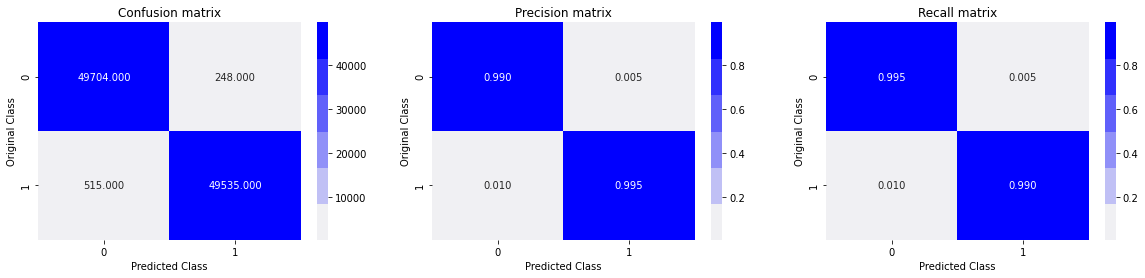

Test confusion_matrix


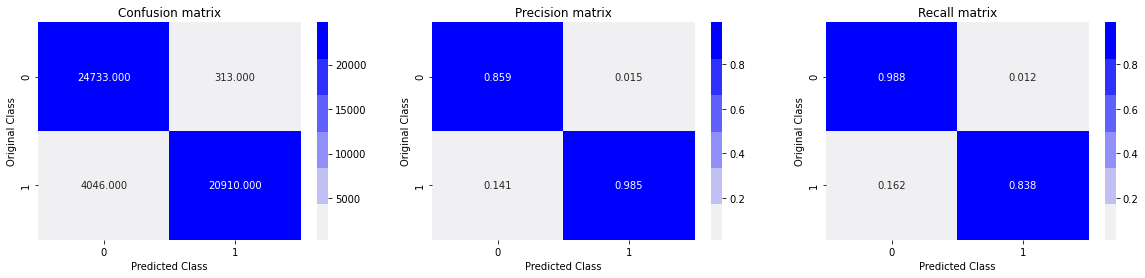

In [60]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,pred_train)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,pred_test)

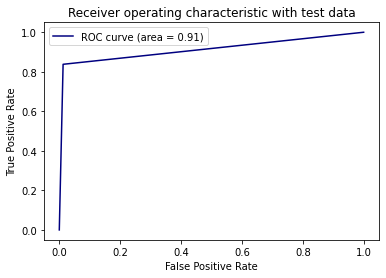

In [61]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,pred_test)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

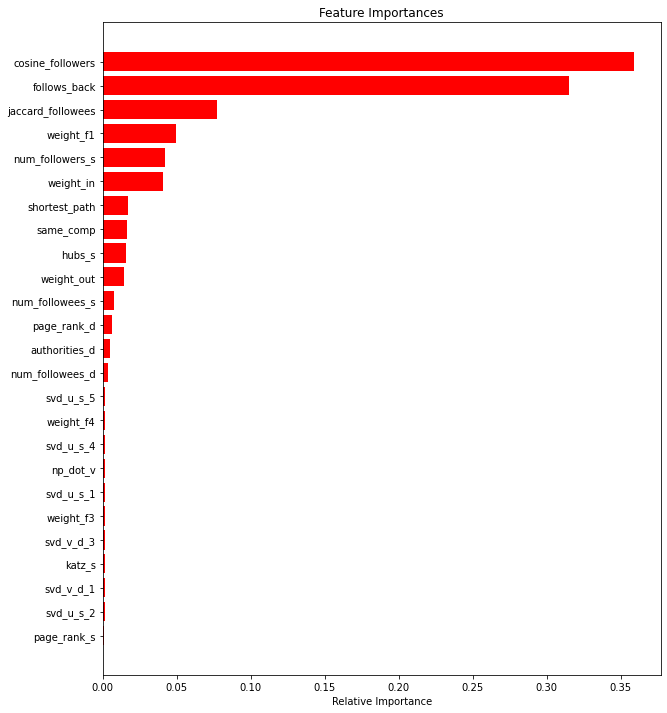

In [62]:
features = df_final_train.columns
importances = xgb_best.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [63]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model \ Parameters","Train f1_score","Test f1_score"]
x.add_row(["RandomForest: ",0.9643266955735856,0.9263264402706634])
x.add_row(["XGBClassifier: ",0.9965995919510341,0.875133547008547])
print(x)

+--------------------+--------------------+--------------------+
| Model \ Parameters |   Train f1_score   |   Test f1_score    |
+--------------------+--------------------+--------------------+
|   RandomForest:    | 0.9643266955735856 | 0.9263264402706634 |
|  XGBClassifier:    | 0.9965995919510341 | 0.875133547008547  |
+--------------------+--------------------+--------------------+
